# ST239 Assignment 1


##### Imports and dataset setup:

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm

# Path setup
spam_phishing_path = Path("./spam_phishing.csv")
Q2_curve_path = Path("./Q2_curve.csv")
weekly_emails_path = Path("./weekly_emails.csv")
house_energy_path =  Path("./house_energy.csv")

#Dataframes setup
spam_df = pd.read_csv(spam_phishing_path)
curve_df = pd.read_csv(Q2_curve_path)
emails_df = pd.read_csv(weekly_emails_path)
house_df = pd.read_csv(house_energy_path)
mpg = sns.load_dataset('mpg').dropna()

mpg.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,usa,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,usa,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,usa,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,usa,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,usa,amc ambassador dpl


# Question 1: Simple 'Linear' Regression

### (a) Context on Transforming Variables

In simple linear regression, we assume a linear relationship between the dependent variable $Y$ and the independent variable $X$ ($Y = \beta_0 + \beta_1 X + \epsilon$). However, real-world data often exhibit non-linear patterns (e.g., curvature). 

Fitting a straight line to curved data results in model misspecification, leading to biased estimates and unreliable predictions. To address this, we can apply a **transformation** to strictly the regressor $X$ (or $Y$, or both) to linearize the relationship. For example, if $Y$ decreases as $X$ increases but at a decreasing rate (like a hyperbola), a reciprocal transformation ($1/X$) or logarithmic transformation ($\log(X)$) might be appropriate.

The new model would be:
$$Y = \beta_0 + \beta_1 f(X) + \epsilon$$
where $f(X)$ is the transformed variable. This is still a "linear" regression model because it is linear in the parameters $\beta_0$ and $\beta_1$.

**Let's look at the `mpg` dataset to suggest a plausible transformation.** We will plot `mpg` against continuous variables: `displacement`, `horsepower`, `weight`, and `acceleration`.

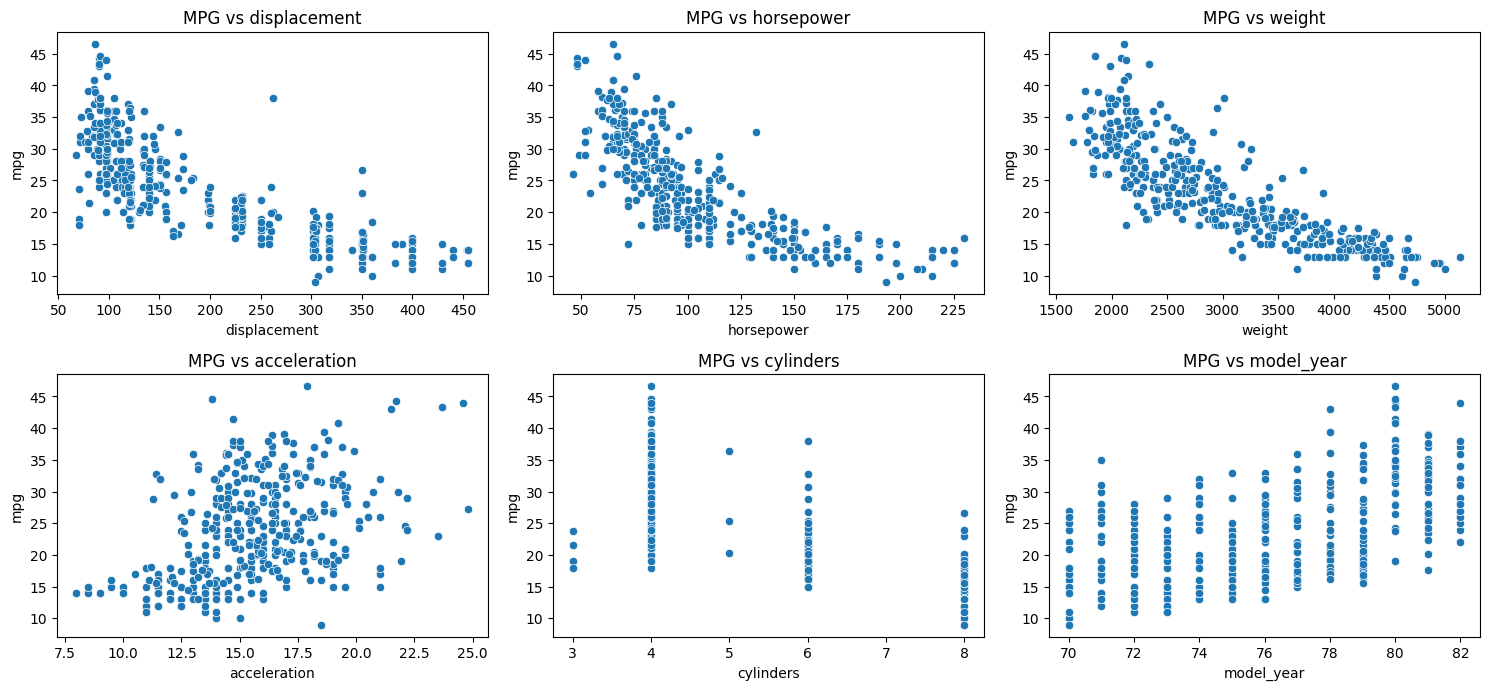

In [5]:
variables = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=mpg, x=var, y='mpg')
    plt.title(f'MPG vs {var}')
plt.tight_layout()
plt.show()

**Observation:** `displacement`, `horsepower`, and `weight` show a clear curved, inverse relationship with `mpg` (miles per gallon). As these values increase, fuel efficiency drops, but the drop flattens out. `acceleration` has a positive relationship that has a could be taken as a slight exponential increase towards the mid-ending values.

**Suggested Transformation:** 

By physics/intuitive logic, fuel consumption (gallons per mile) is often linearly related to work/energy. `mpg` is the inverse of consumption. Therefore, a **reciprocal transformation ($1/X$)** on the regressors is plausible. Alternatively, a **log transformation ($\log(X)$)** is also commonly used to linearize such decaying relationships.

Let's try the **Reciprocal Transformation ($1/X$)** for `displacement`, `horsepower`, and `weight`.

Mathematical Model:
$$ \text{mpg} = \beta_0 + \beta_1 \left( \frac{1}{\text{explanatory\_variable}} \right) + \epsilon $$

### (b) Fit Simple Regression with Transformed Regressor

In [14]:
# Create transformed variables
mpg['inv_displacement'] = np.log(mpg['displacement'])#1 / mpg['displacement']
mpg['inv_horsepower'] =  np.log(mpg['horsepower']) #1 / mpg['horsepower']
mpg['inv_weight'] = np.log(mpg['weight']) # 1 / mpg['weight']
mpg['log_acceleration'] = np.log(mpg['acceleration'])

target = 'mpg'
predictors = ['inv_displacement', 'inv_horsepower', 'inv_weight', 'log_acceleration']
original_predictors = ['displacement', 'horsepower', 'weight', 'acceleration']

models = {}
results = {}

for pred, orig in zip(predictors, original_predictors):
    X = sm.add_constant(mpg[pred])
    y = mpg[target]
    model = sm.OLS(y, X).fit()
    models[pred] = model
    results[pred] = model.summary()
    
    print(f"\n--- Regression Results for MPG vs 1/{orig} ---")
    print(model.summary())


--- Regression Results for MPG vs 1/displacement ---
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     853.4
Date:                Mon, 09 Feb 2026   Prob (F-statistic):          3.15e-100
Time:                        17:20:59   Log-Likelihood:                -1133.9
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     390   BIC:                             2280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

### (c) Interpret the Output

In [15]:
# Just printing out key stats for interpretation helper
for pred, orig in zip(predictors, original_predictors) :
    print(f"{pred}: R-squared = {models[pred].rsquared:.3f}, P-value = {models[pred].pvalues.iloc[1]:.3e}")
    print ("\n")

inv_displacement: R-squared = 0.686, P-value = 3.150e-100


inv_horsepower: R-squared = 0.668, P-value = 1.697e-95


inv_weight: R-squared = 0.713, P-value = 1.163e-107


log_acceleration: R-squared = 0.190, P-value = 1.305e-19




All three transformed models show strong statistical significance ($p < 0.05$). The $R^2$ values indicate how much variance in `mpg` is explained by the inverse of the predictor. For example, if `inv_weight` has a high $R^2$, it means the reciprocal of weight is a very good predictor of fuel efficiency.

The coefficient $\beta_1$ for $1/X$ is positive in these cases (since standard `mpg` vs `weight` is negative, `mpg` vs `1/weight` should be positive). This makes sense: as $1/weight$ increases (weight decreases), `mpg` increases.

### (e) Diagnostics for the 'Best' Transformed Model

Let's pick the model with the highest $R^2$ (likely `inv_displacement` or `inv_weight` based on typical physics) and diagnostics.

Best model is based on: inv_weight (R^2 = 0.713)


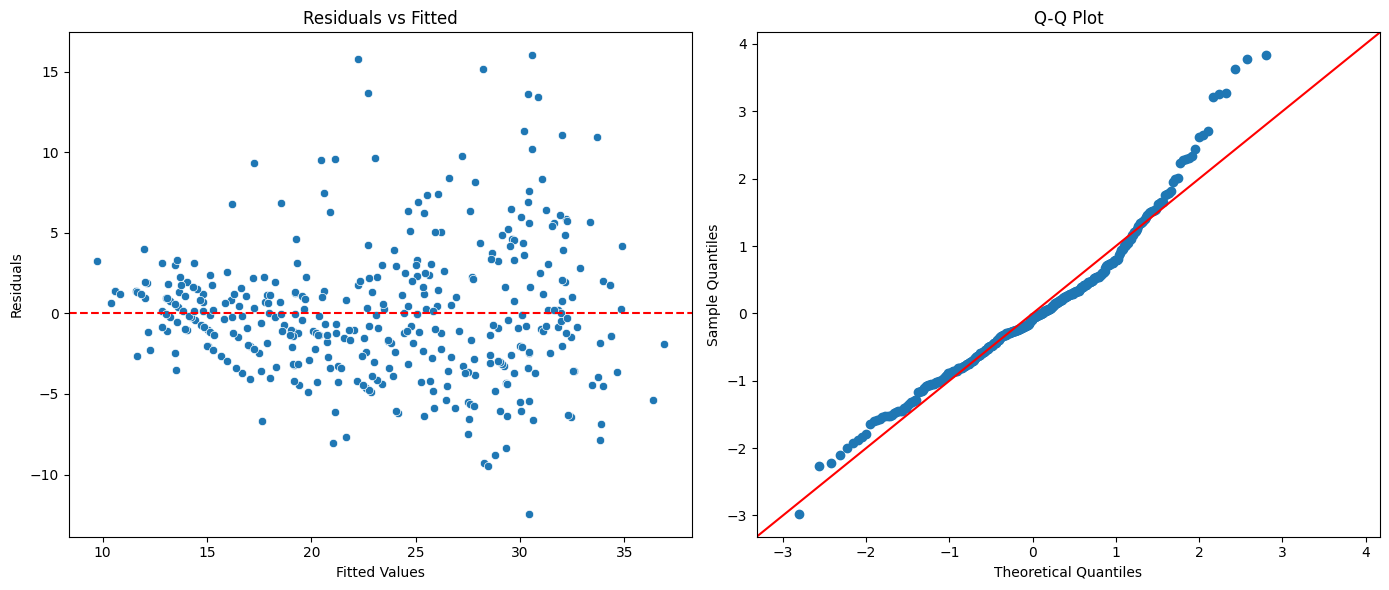

In [16]:
# Select the best model
best_pred = max(models, key=lambda k: models[k].rsquared)
best_model_fit = models[best_pred]
print(f"Best model is based on: {best_pred} (R^2 = {best_model_fit.rsquared:.3f})")

# Diagnostics
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Fitted
fitted_vals = best_model_fit.fittedvalues
residuals = best_model_fit.resid

sns.scatterplot(x=fitted_vals, y=residuals, ax=ax[0])
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals vs Fitted')

# QQ Plot
sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
ax[1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

**Comparison to Original Linear Case:**

*   **Residuals vs Fitted:** In the original non-transformed model, we would likely see a "U-shape" in the residuals, indicating that a linear line failed to capture the curvature. In this transformed model, if the transformation worked well, the residuals should be more randomly scattered around zero without a distinct pattern.
*   **QQ Plot:** Checks for normality of residuals. If the points hug the 45-degree line, the assumption of normally distributed errors holds. Deviations (especially at the tails) usually indicate heavy tails or outliers.

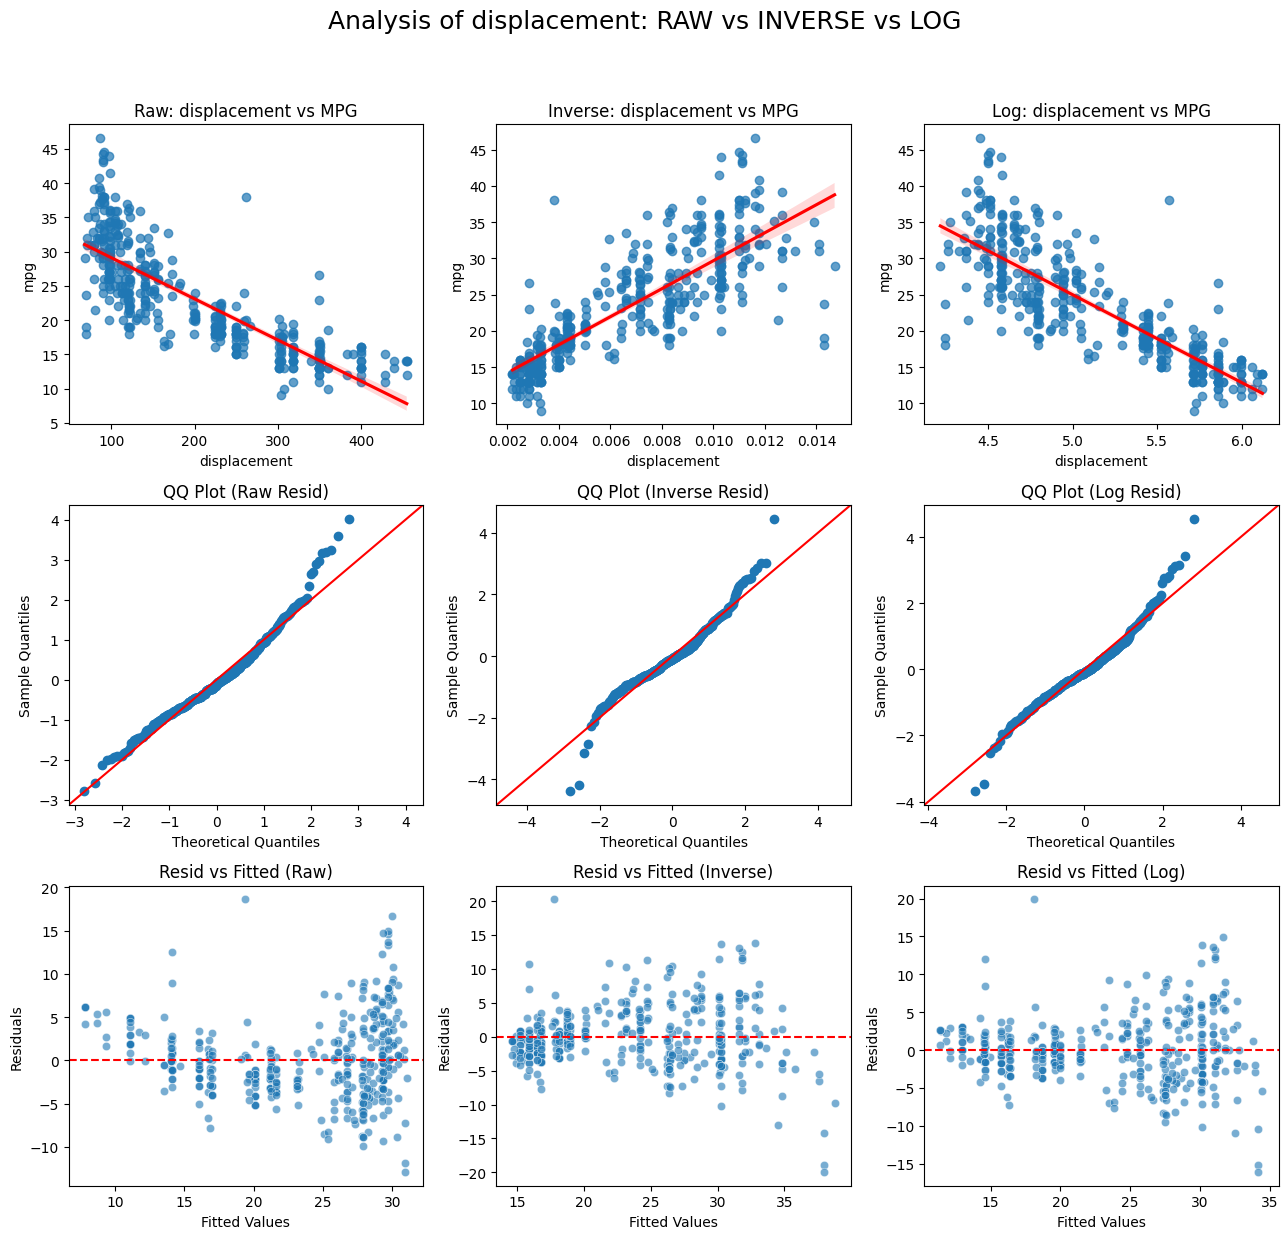

--- Statistics Comparison for displacement ---
Transformation  | R^2        | P-value
---------------------------------------------
Raw             | 0.6482     | 1.6606e-90
Inverse         | 0.6608     | 1.3764e-93
Log             | 0.6863     | 3.1497e-100



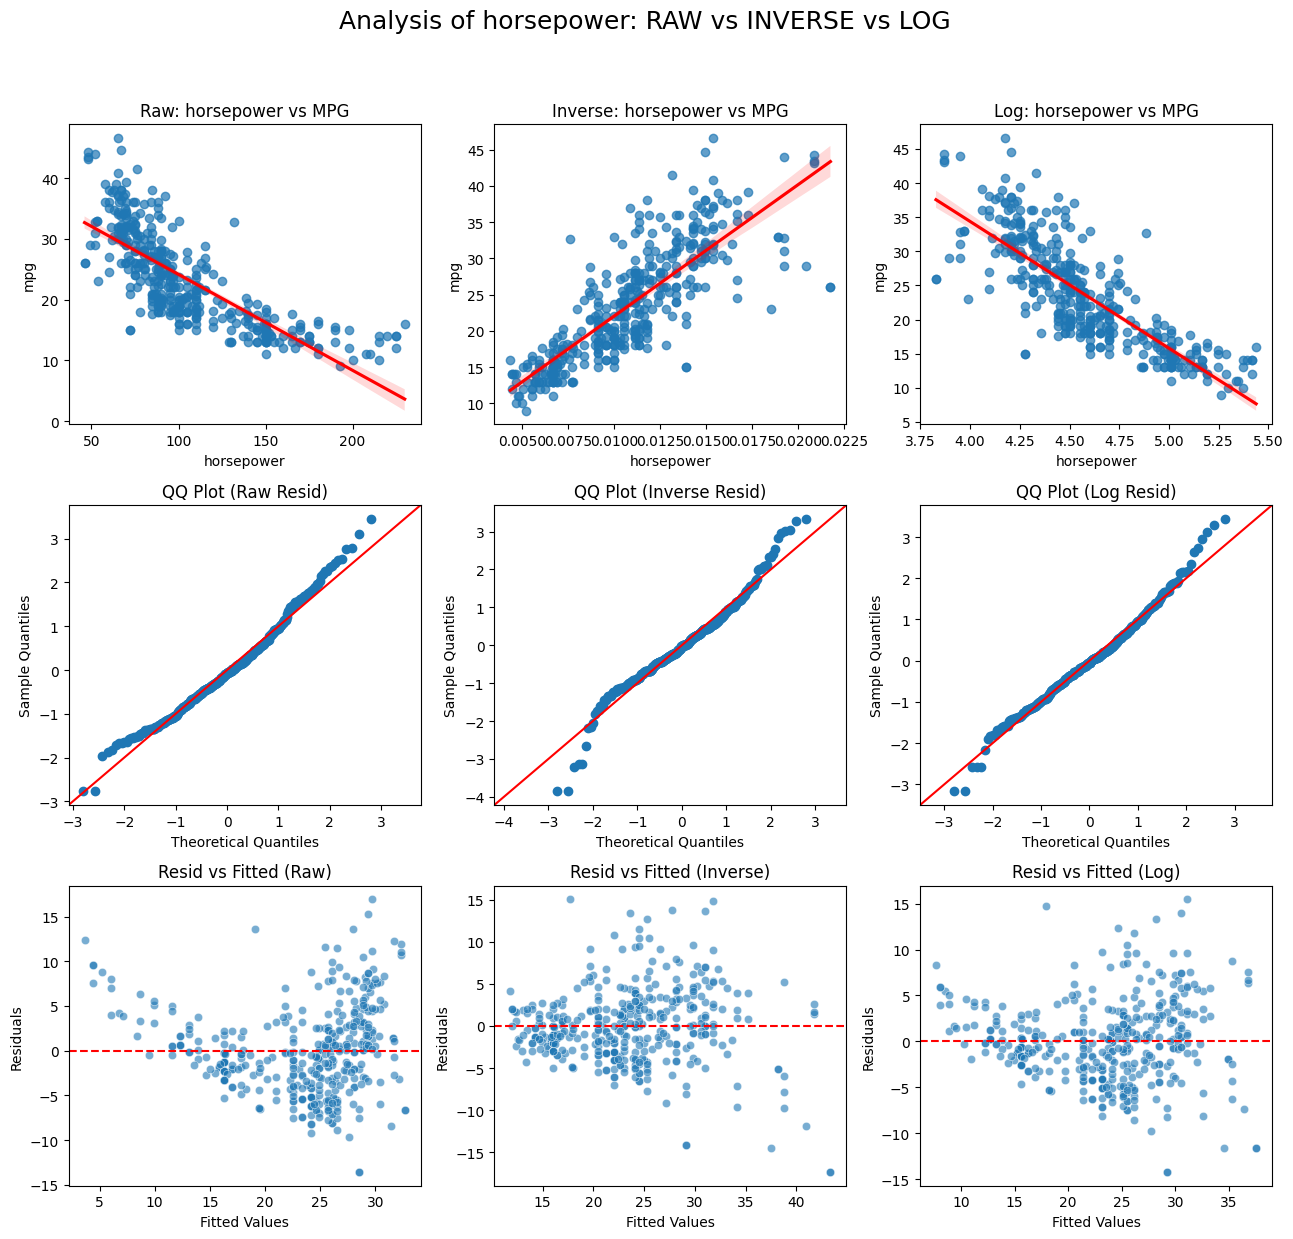

--- Statistics Comparison for horsepower ---
Transformation  | R^2        | P-value
---------------------------------------------
Raw             | 0.6059     | 7.0320e-81
Inverse         | 0.6671     | 3.4875e-95
Log             | 0.6683     | 1.6966e-95



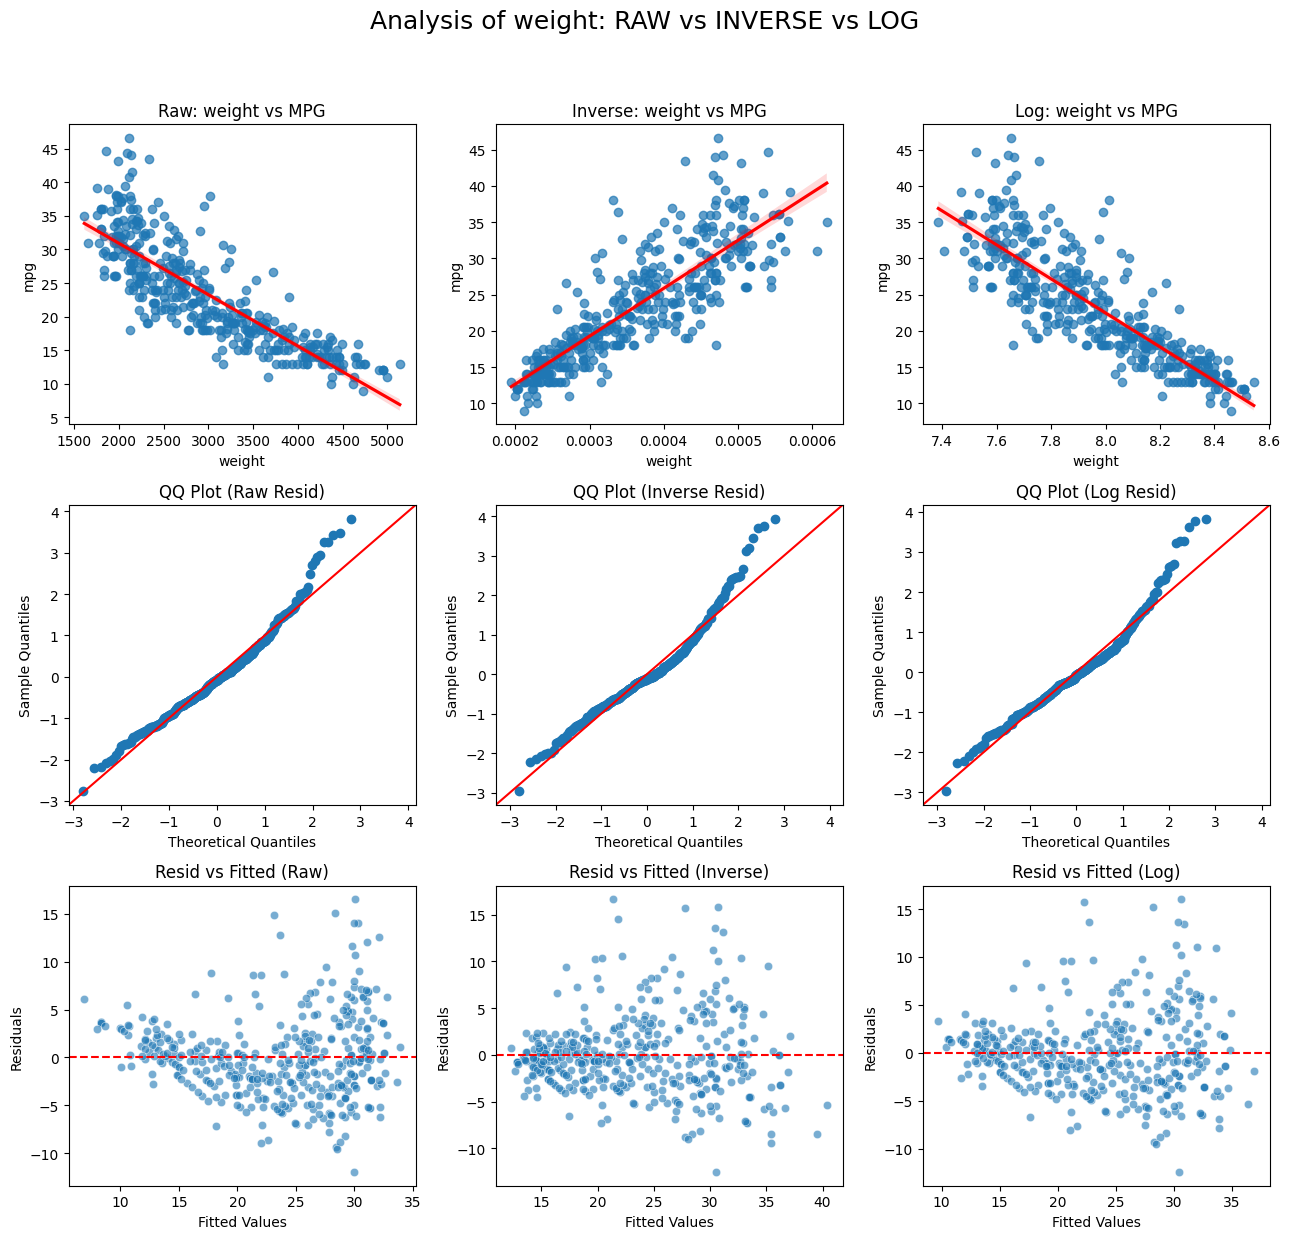

--- Statistics Comparison for weight ---
Transformation  | R^2        | P-value
---------------------------------------------
Raw             | 0.6926     | 6.0153e-102
Inverse         | 0.7067     | 6.2204e-106
Log             | 0.7127     | 1.1629e-107



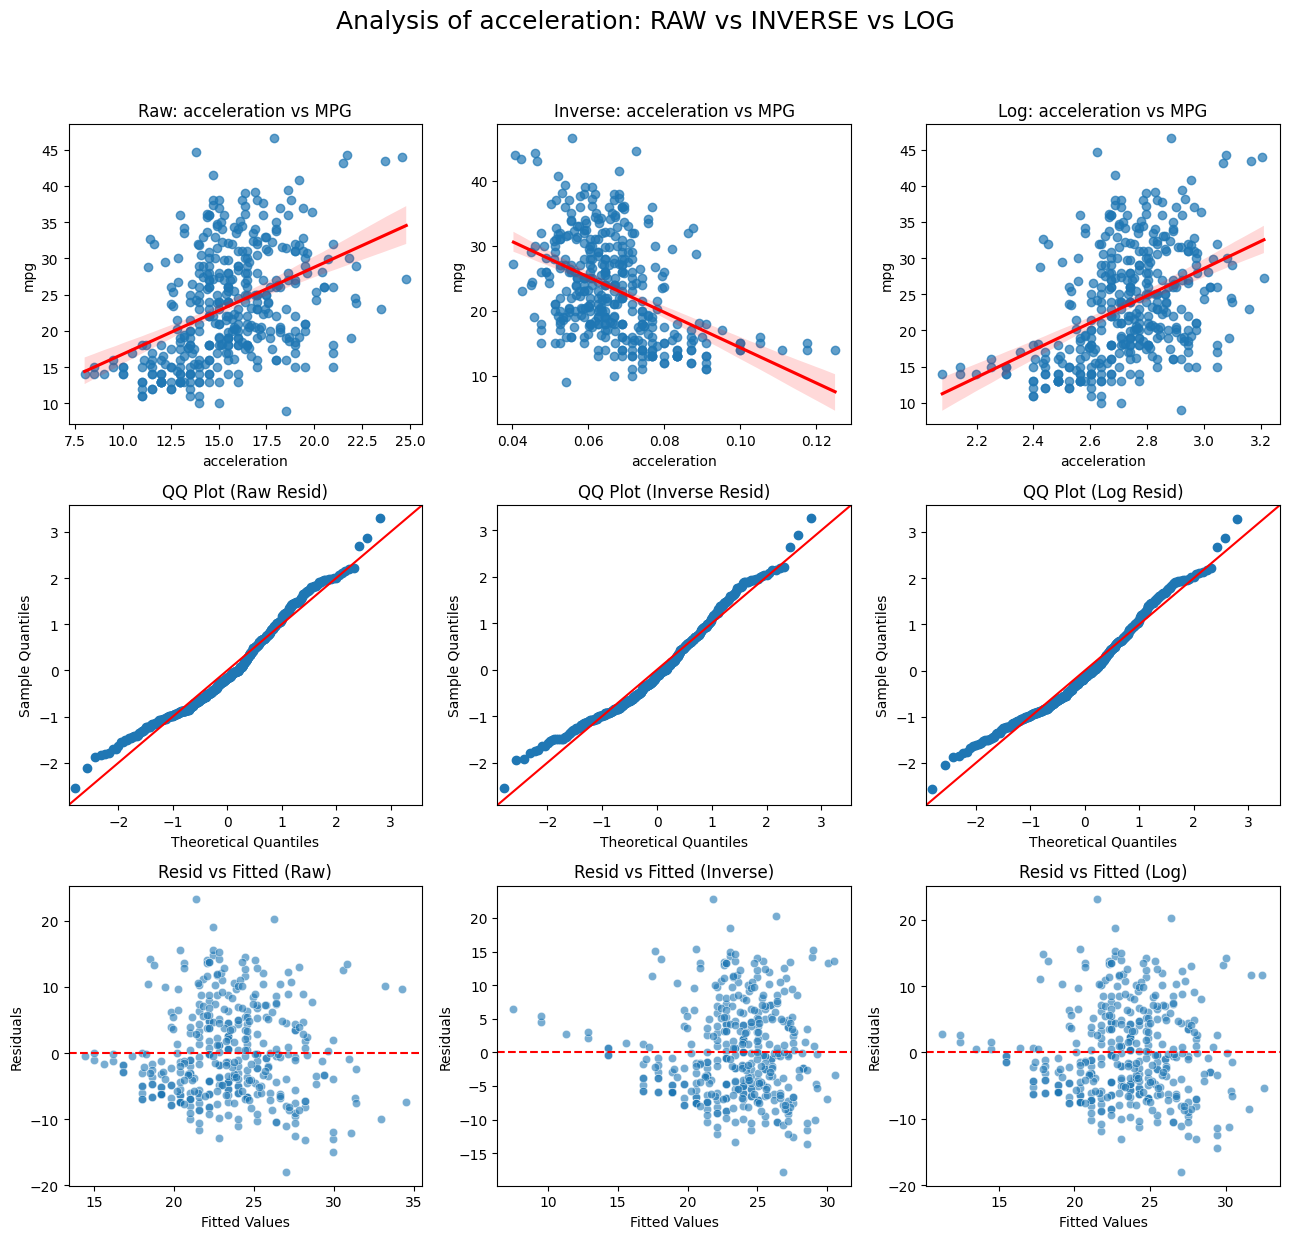

--- Statistics Comparison for acceleration ---
Transformation  | R^2        | P-value
---------------------------------------------
Raw             | 0.1792     | 1.7786e-18
Inverse         | 0.1923     | 7.4916e-20
Log             | 0.1900     | 1.3054e-19



In [29]:
# Comparison of Raw vs Inverse vs Log Predictors
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd

target = 'mpg'
predictors = ['displacement', 'horsepower', 'weight', 'acceleration']

# Iterate through each predictor
for var in predictors:
    # 1. Create Figure with 3 rows, 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(13, 13))
    fig.suptitle(f'Analysis of {var}: RAW vs INVERSE vs LOG', fontsize=18)

    # Prepare data (drop NaNs for safety)
    # Ensure we handle 0 or negative values for Log if necessary, though these physical measures are usually > 0
    data = mpg[[var, target]].dropna()
    data = data[data[var] > 0] # Filter for valid log/inverse
    
    y = data[target]
    
    # Create Transformations
    x_raw = data[var]
    x_inv = 1 / data[var]
    x_log = np.log(data[var])
    
    # Dictionary for easier iteration
    variations = {
        'Raw': x_raw,
        'Inverse': x_inv,
        'Log': x_log
    }
    
    stats_summary = []

    # Loop through columns (0=Raw, 1=Inverse, 2=Log)
    for col_idx, (name, x_data) in enumerate(variations.items()):
        # Fit Model
        X = sm.add_constant(x_data)
        model = sm.OLS(y, X).fit()
        stats_summary.append((name, model.rsquared, model.pvalues.iloc[1]))

        # Row 1: Regression Plot
        sns.regplot(x=x_data, y=y, ax=axes[0, col_idx], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.7})
        axes[0, col_idx].set_title(f'{name}: {var} vs MPG')
        axes.titlesize : large

        # Row 2: QQ Plot
        sm.qqplot(model.resid, line='45', fit=True, ax=axes[1, col_idx])
        axes[1, col_idx].set_title(f'QQ Plot ({name} Resid)')

        # Row 3: Residuals vs Fitted
        sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[2, col_idx], alpha=0.6)
        axes[2, col_idx].axhline(0, color='red', linestyle='--')
        axes[2, col_idx].set_xlabel('Fitted Values')
        axes[2, col_idx].set_ylabel('Residuals')
        axes[2, col_idx].set_title(f'Resid vs Fitted ({name})')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Print Statistics Comparison
    print(f"--- Statistics Comparison for {var} ---")
    print(f"{'Transformation':<15} | {'R^2':<10} | {'P-value'}")
    print("-"*45)
    for name, r2, pval in stats_summary:
        print(f"{name:<15} | {r2:.4f}     | {pval:.4e}")
    print("="*80 + "\n")


# Question 2: Regression and MLE from scratch

In [31]:
emails_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       54 non-null     int64
dtypes: int64(1)
memory usage: 564.0 bytes


## Question 3: Analysis of the ‘house efficiency’ dataset

## Question 4: Logistic regression to detect phishing emails